In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf, to_date
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
import re

In [2]:
print(pyspark.__version__)
 


3.2.4


In [3]:
df = (spark.read
      .format("mongo")
      .option("spark.mongodb.input.uri", "mongodb://localhost:27017")
      .option("spark.mongodb.input.database", "TrumpDB")
      .option("spark.mongodb.input.collection", "TrumpCollection")
      .option("spark.mongodb.input.partitioner", "MongoSinglePartitioner")
      .load())


In [4]:
print(df.columns)

['_id', 'candidate_id', 'created_at', 'device', 'favorite_count', 'id', 'inserted_at', 'lang', 'polarity', 'retweet_count', 'state', 'subjectivity', 'tw_user_id', 'tweet_id', 'tweet_text', 'updated_at']


In [5]:
df = df.select('candidate_id', "created_at", "tweet_text")

In [6]:
df_no_nulls = df.na.drop()
tweets = df_no_nulls.filter(df.candidate_id == 2)

In [7]:
analyzer = SentimentIntensityAnalyzer()

def preprocess_tweet(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # remove URLs
    text = re.sub(r'\@\w+|\#','', text) # remove mentions and hashtags
    text = re.sub(r'RT[\s]+', '', text) # remove retweets
    return text

def analyze_sentiment(text):
    text = preprocess_tweet(text)
    return analyzer.polarity_scores(text)["compound"]

sentiment_udf = udf(analyze_sentiment, FloatType())
spark.udf.register("sentiment_udf", sentiment_udf)

<function __main__.analyze_sentiment(text)>

In [8]:
# Convert timestamp to date
tweets = tweets.withColumn("date", to_date(col("created_at")))

# Calculate sentiment score for each tweet
tweets = tweets.withColumn("sentiment", sentiment_udf(col("tweet_text")))


In [9]:
tweets = tweets.select('tweet_text','date','sentiment')

In [10]:
from pyspark.sql.functions import year

# filter out out-of-range dates
tweets = tweets.filter((year("date") >= 1) & (year("date") <= 9999))

In [11]:
daily_sentiment_df = tweets.groupBy("date") \
    .agg(F.mean("sentiment").alias("avg_sentiment")) \
    .orderBy("date")

In [17]:
daily_sentiment_df.show()

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [12]:
daily_sentiment_pd = daily_sentiment_df.toPandas()

In [15]:
daily_sentiment_pd.to_csv('daily_sentiment_pd',index=False)

Text(0, 0.5, 'Sentinment')

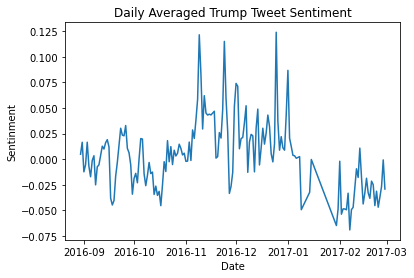

In [16]:
plt.plot(daily_sentiment_pd['date'],daily_sentiment_pd['avg_sentiment'])
plt.title('Daily Averaged Trump Tweet Sentiment')
plt.xlabel('Date')
plt.ylabel('Sentinment')